# Install prerequsits

In [1]:
!pip install tensorflow maxminddb-geolite2 -q
!conda install pyarrow sqlparse -q
!pip install ibmcloudsql -q

import ibmcloudsql, sqlparse, sklearn.decomposition, scipy, matplotlib, time
import pandas as pd, numpy as np, matplotlib.pyplot as plt, networkx as nx, tensorflow as tf, seaborn as sn

from geolite2 import geolite2
from scipy import signal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, confusion_matrix

Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - pyarrow
    - sqlparse


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    re2-2019.08.01             |       he6710b0_0         613 KB
    glog-0.4.0                 |       he6710b0_0         128 KB
    libprotobuf-3.6.0          |       hdbcaa40_0         4.1 MB
    sqlparse-0.3.0             |             py_0          31 KB
    cupti-10.0.130             |                0         1.8 MB
    pyarrow-0.13.0             |   py36he6710b0_0         2.2 MB
    openssl-1.1.1d             |       h7b6447c_0         3.7 MB
    tensorflow-base-1.13.1     |gpu_py36h8d69cac_0       293.8 MB
    arrow-cpp-0.13.0           |   py36h117bdfb_0         3.5 MB
    double-conversion-3.1.5    |       he6710b0_1         233 KB
    cudnn-7.6.0                |     

ImportError: Traceback (most recent call last):
  File "/opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/opt/conda/envs/Python36/lib/python3.6/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/opt/conda/envs/Python36/lib/python3.6/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: libcuda.so.1: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

# Prepare and Execute SQL Query (flow logs from COS to memory)

In [4]:
# instance CRN for the SQL Query instance - Look for the 'SQL Query app' under https://console.bluemix.net/dashboard/apps 
instnacecrn="crn:v1:bluemix:public:sql-query:us-south:a/01fedb4f3ff70b186d83cdb1e1df6879:3aa64b96-c4cc-4880-9ba0-efdd62bb838a::"
# API key for an IBM Cloud Object Storage bucket - under https://console.bluemix.net/iam/#/apikeys execute Manage->Security->Platform API Keys, click Create 
apikey="ZHdGyRMu9qTfy_dHeQNqnVxYmM_EtGwZtkGr2cE_sLtc"
# Query results destination - Follow the format as bellow
targeturl="cos://us-south/sql-3aa64b96-c4cc-4880-9ba0-efdd62bb838a/result/"    
# The SQL Query to perform - Follow the format as bellow (might change the */* to fit regex that match date/need/other)
sql = """
WITH flows as (SELECT explode(data) flow FROM cos://us-south/sa-seclogs-eran/IBM/netflow/vpc-region/vpc-guid/0/ingress/*/* STORED AS JSON)
SELECT flow.UUID, flow.Status, flow.Version, flow.Start, flow.Last, flow.Network.A AS src_ip, flow.Transport.A AS src_port, flow.Network.B AS dst_ip, flow.Transport.B AS dst_port, flow.Transport.Protocol, flow.Metric.ABPackets, flow.Metric.BAPackets, flow.Metric.ABBytes, flow.Metric.BABytes FROM flows"""

sqlClient = ibmcloudsql.SQLQuery(apikey, instnacecrn, client_info='SQL Query FlowLogs')
sqlClient.logon()
sql_with_target = sql + ' INTO {} STORED AS CSV'.format(targeturl)

print ("Start executing. this might take a while, so wait for it... To follow progress use:")
sqlClient.sql_ui_link()
result_df = sqlClient.run_sql(sql_with_target)
flowlogs_df = result_df.astype({'Start': 'datetime64[ms]','Last': 'datetime64[ms]',}).drop_duplicates()
# Artificially add an Action field, which gets an ACCEPTED value when dst_port=22. To be removed in the future
flowlogs_df['Action'] = np.where(flowlogs_df['dst_port']!=22.0, 'ACCEPTED', 'REJECTED')
flowlogs_df['Total_Packets'] = flowlogs_df['ABPackets'] + flowlogs_df['BAPackets']
flowlogs_df['Total_Bytes'] = flowlogs_df['ABBytes'] + flowlogs_df['BABytes']

print("Completed.")

Start executing. this might take a while, so wait for it... To follow progress use:
https://sql-query.cloud.ibm.com/sqlquery/?instance_crn=crn:v1:bluemix:public:sql-query:us-south:a/01fedb4f3ff70b186d83cdb1e1df6879:3aa64b96-c4cc-4880-9ba0-efdd62bb838a::
Completed.


In [5]:
from ibm_botocore.client import Config
import ibm_boto3

credentials = {
    'IAM_SERVICE_ID': 'iam-ServiceId-5cead18f-7eb5-487d-93ad-d848f90a46e6',
    'IBM_API_KEY_ID': 'q2bzIZBPZ9Lkrz8uDBmr5l44Re56xWFkPlGLOcjuEzRF',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.ng.bluemix.net/oidc/token',
    'BUCKET': 'flowlogsanalytics-donotdelete-pr-7vrxdvrveals1x',
    'FILE': 'ts.csv'
}

cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])

cos.download_file(Bucket=credentials['BUCKET'], Key='ts.csv', Filename='ts.csv')

ext_data = pd.read_csv('ts.csv')
ext_data = ext_data.rename(columns={"met_val": "Ext_data"})

In [6]:
import types

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_f391fb1040284eb4a7dcb9a54e69405b = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='pnJqEzaqHNnEow7rwz_MeXU-OgB_rTWdpfoGYdIgJ04N',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_f391fb1040284eb4a7dcb9a54e69405b.get_object(Bucket='analytics-donotdelete-pr-hlnupjfgg1kqzy',Key='art.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

art_df = pd.read_csv(body)
art_df = art_df.astype({'Start': 'datetime64[ms]','Last': 'datetime64[ms]',})

# Utility Functions

In [7]:
# Finds country by IP address.
# Args: ip - String represents an IP address.
# Returns: String represents the corresponding country name.
def get_country(ip):
    try:
        x = geo.get(ip)
    except ValueError:
        return pd.np.nan
    try:
        return x['country']['names']['en'] if x else pd.np.nan
    except KeyError:
        return pd.np.nan

    
# Converts integer to its Metric Prefix (MP) representation.
# Args: num - Integer.
# Returns: A string with the corresponding MP representation.
def number_format(num):
    magnitude = 0
    while num >= 1000:
        magnitude += 1
        num /= 1000.0
    return '%.3f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])


# Iteratively scales an array, obtaining predefined max value and max/min ratio. Useful for illustration tasks. 
# Args: arr - Array of numbers. max_val - the desired max value.
# Returns: A scaled array.
def scale(arr, max_val, ratio=100):
    while np.max(arr) > ratio * np.min(arr):
        arr = np.sqrt(arr)
    arr = arr * max_val / np.max(arr)
    return arr


# Filters according to "Start" column and the given dates.
# Args: df - Dataframe in flow_logs format. (year1, month1, day1) - Start date. (year2, month2, day2) - end date.
# Retruns: A filtered dataframe.
def date_filter(df, year1, month1, day1, year2, month2, day2):
    start_date = pd.to_datetime('%s-%s-%s' % (year1, month1, day1))
    end_date = pd.to_datetime('%s-%s-%s' % (year2, month2, day2))
    mask = (df['Start'] >= start_date) & (df['Start'] <= end_date)
    return df.loc[mask]


## To be removed.
def get_data(kind):
    
    if kind == "Ext_data":
        return ext_data
    
    if kind == "Art_data":
        return art_df.set_index('Start')[['ABBytes']].resample('0.5Min').sum().fillna(0) 
    
    tot_df = flowlogs_df.set_index('Start')[['Total_Packets', 'Total_Bytes']].resample('1H').sum().fillna(0)  

    samples_num = len(tot_df.index)
    sin_arr1 = [np.sin(2*np.pi*x/24) * 0.1 * np.max(tot_df["Total_Packets"]) for x in range(samples_num)]
    sin_arr2 = [np.sin(2*np.pi*x/4) * 0.01 * np.max(tot_df["Total_Packets"]) for x in range(samples_num)]
    tot_df["Noisy_Packets"] = tot_df["Total_Packets"] + sin_arr1 + sin_arr2
    
    tot_df["flows"] = flowlogs_df.set_index('Start').resample('1H').size().replace(0, np.nan)
    tot_df["averageFlowPacket"] = tot_df["Total_Packets"] / tot_df["flows"]
    tot_df["averageFlowByte"] = tot_df["Total_Bytes"] / tot_df["flows"]
    tot_df["averagePacketSize"] = tot_df["Total_Bytes"] / tot_df["Total_Packets"]
    tot_df["flowBehavior"] = tot_df["flows"] / tot_df["averagePacketSize"]
    tot_df = tot_df.fillna(0)

    if kind == "Total_Packets":
        return tot_df.loc[:, ["Total_Packets"]]
    if kind == "Noisy_Packets":
        return tot_df.loc[:, ["Noisy_Packets"]] 
    if kind == "Att":
        return tot_df[["flows", "averageFlowPacket", "averageFlowByte", "averagePacketSize", "flowBehavior"]]

    
# Smoothes dataframe in a column-wise manner using moving average.
# Args: df - Dataframe. w - Window size. s - Stride size.  
# Retruns: Smoothed dataframe.
def smooth_MA(df, w, s=1):
    samples_num = int(len(df.index) / s) - w
    indices = [df.index[i*s+int(0.5*w)] for i in range(samples_num)]
    smoothed_df = pd.DataFrame(index=indices, columns=df.columns)
    for c in df.columns:
        smoothed_df[c] = [np.mean(df[c].values[i:i+w]) for i in samples_num]
    return smoothed_df


# Smoothes dataframe in a column-wise manner using low-pass filter.
# Args: df - Dataframe. coeff - Amount of filter coefficients. thresh - The attenuation frequency. s - Stride size. 
# Retruns: Smoothed dataframe.
def smooth_LP(df, coeff=4, thresh=0.1, s=1):
    samples_num = int(len(df.index) / s)
    indices = [df.index[i*s] for i in range(samples_num)]
    smoothed_df = pd.DataFrame(index=indices, columns=df.columns)
    sample_indices = [i*s for i in range(samples_num)]
    b, a = signal.butter(coeff, thresh)
    for c in df.columns:
        filtered = signal.lfilter(b, a, df[c].values)
        smoothed_df[c] = [filtered[i] for i in sample_indices]
    return smoothed_df


# Normalizes dataframe columns to range [0, 1] using min-max method.
# Args: df - Dataframe.
# Returns: Normalized dataframe.
def normalize(df):
    normalized_df = df.copy()
    for c in normalized_df.columns:
        normalized_df[c] = ((df[c] - np.min(df[c])) / (np.max(df[c]) - np.min(df[c]))).fillna(0)
    return normalized_df


# Standardizes dataframe in a column-wise manner.
# Args: df - Dataframe.
# Returns: Standardized dataframe.
def standardize(df):
    standardized_df = df.copy()
    for c in standardized_df.columns:
        standardized_df[c] = ((df[c] - np.mean(df[c])) / (np.std(df[c]))).fillna(0)
    return standardized_df


# Finds extremely-high values within an array.
# Args: scores - Array of values. thresh - Amount of STDs.
# Returns: Array of indices in which the value exceeeds MEAN+thresh*STD.
def find_anomalies(scores, thresh=3):
    threshold = np.mean(scores) + thresh * np.std(scores)
    return [i for (i, x) in enumerate(scores) if x > threshold]


# Marks anomalies in a 1d-signal.
# Args: x - indices of a signal. y - values of a signal. anomaly_indices - Indices in which anomalies occur. draw_trends - Whether to split the graph into segments.
# Returns: None.
def anomaly_visualization(x, y, anomaly_indices, draw_trends=False):
    plt.figure(figsize=(20,5))
    if draw_trends == False:
        plt.plot(x, y, 'b')
        for i in anomaly_indices:
            plt.plot(x[i-1:i+1], y[i-1:i+1], 'r', linewidth=2)
    else:
        anomaly_indices = anomaly_indices + [0, len(x)-1]
        anomaly_indices.sort()        
        for i in range(1, len(anomaly_indices)):
            start, end = anomaly_indices[i-1], anomaly_indices[i]
            mid = int(0.5 * (start + end - 1))
            plt.plot(x[start:end], y[start:end])
            plt.annotate("Avg: %.2f" % np.mean(y[start:end]), xy=(x[mid], 0.1*np.max(y) + y[mid]), ha='center', bbox=dict(boxstyle="round4", fc="1."))
            if i < len(anomaly_indices) - 1:
                plt.plot(x[end-1:end+1], y[end-1:end+1], 'r', dashes=[3, 3])
    plt.xlabel('Time', fontsize=20), plt.ylabel('Packets', fontsize=20)
    plt.ylim(1.5 * np.min(y), 1.5 * np.max(y))
    plt.title("Signal Anomalies", fontsize=20)
    plt.show()
    
    
# Turns one-dimensional signal into multi-dimensional signal by converting contiguous subsequences to vectors. Useful as a data preperation for time-series prediction.
# Args: df - 1d signal. window - The subsequence size.
# Returns: df_data represents a multi dimensional signal in which row i consists of the [i : i+window] values of the original signal. df_labels is a shift of df by window steps. 
def shingle(df, window):
    df_data, df_labels = pd.DataFrame(index=df.index[window:], columns=range(len(df.columns)*window)), pd.DataFrame(index=df.index[window:], columns=range(len(df.columns)))
    values = df.values.tolist()
    for i in range(len(df_data.index)):
        arr = []
        for k in range(window):
            arr = arr + values[i+k] 
        df_data.iloc[i] = arr
        df_labels.iloc[i] = df.iloc[window+i].values
    return df_data, df_labels


# Plots confusion matrix.
# Args: (a, b) - Binary arrays with the same dimension.
# Returns: None.
def plot_confusion_matrix(a, b):
    cm = confusion_matrix(a, b)
    plt.figure(figsize = (7,7))
    sn.heatmap(cm, annot=True, annot_kws={"size": 12}, cmap='Blues', fmt='g', cbar=False, xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.xlabel('Predicted', fontsize=16), plt.ylabel('Actual', fontsize=16)
    plt.show()

    
# Caclculates convolution layer.
# Args: x - Signal. W - Convolution kernel. stride - Convolution stride.
# Returns: Convolution layer.
def conv2d(x, W, stride=1):
    return tf.nn.conv2d(x, W, strides=stride, padding='SAME')


# Caclculates pooling layer.
# Args: x - Signal. stride - Pooling size.
# Returns: Pooling layer.
def max_pool(x, stride=2):
    return tf.nn.max_pool(x, ksize=[1, 1, stride, 1], strides=[1, 1, stride, 1], padding='SAME')


# Initializes weight variables using xavier method.
# Args: kind - layer kind (FC / conv). (size_in, size_out) - dimensiones for FC layer.
# Returns: Initialized weight variables.
def get_variables(kind, size_in=None, size_out=None):
    initializer = tf.contrib.layers.xavier_initializer()
    if kind == "FC":
        return tf.Variable(initializer([size_in, size_out])), tf.Variable(initializer([size_out]))
    elif kind == "conv":
        return tf.Variable(initializer([1, 5, 1, 1])), tf.Variable(initializer([1]))


# Builds Tensorflow graph.
# Args: sess - Tensorflow session. saver - Tensorflow saver. init - Tensorflow initializer. is_initial - Whether the graph should be restored. path - Location of the graph to be restored.
# Returns: None.
def build_model(sess, saver, init, is_initial, path):
    if is_initial==True:
        sess.run(init)
        print("Model initialized.")
    else:
        saver.restore(sess, save_path=path)
        print("Model restored.")
    print("Start training...")

    
# Predicts time-series values using fully-convolutional neural network.
# Args: (train_set, test_set) - Dataframes with shingled time-series. (train_labels, test_labels) - Dataframes with the next value of the time series. 
#       step - Training rate. max_epochs - Number of training epochs. batch_size - Training batch size. activation - Tensorflow activation function. reg_coeff - Regularization coefficient.
#       tolerance - Amount of consequent epochs in which test loss can increase without stopping the training phase. is_initial - Whether the graph should be restored.
# Returns: Array of the predicted values.
def cnn_regression(train_set, test_set, train_labels, test_labels, step=0.001, max_epochs=100, batch_size=64, activation=tf.nn.tanh, tolerance=0, reg_coeff=0, is_initial=False):
    tf.reset_default_graph() 
    sample_len = len(train_set.columns)
    W1, b1 = get_variables(kind="conv")
    W2, b2 = get_variables(kind="FC", size_in=int(sample_len/2), size_out=int(sample_len/4))
    W3, b3 = get_variables(kind="FC", size_in=int(sample_len/4), size_out=1)
    reg_term = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3)
    x, y = tf.placeholder(tf.float32, [None, sample_len]), tf.placeholder(tf.float32, [None, 1])
    x_reshaped = tf.reshape(x, [-1, 1, sample_len, 1])
    x1 = activation(max_pool(conv2d(x_reshaped, W1, stride = 1) + b1))
    x1 = tf.reshape(x1, [-1, int(sample_len/2)])
    x2 = activation(tf.matmul(x1, W2) + b2)
    x3 = tf.matmul(x2, W3) + b3
    loss = tf.reduce_mean(tf.square(x3 - y)) + reg_coeff*reg_term
    train = tf.train.RMSPropOptimizer(step).minimize(loss, var_list=[W1, W2, W3, b1, b2, b3])
    saver = tf.train.Saver()
    save_path='path'
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        build_model(sess, saver, init, is_initial, save_path)
        test_loss, count = np.inf, 0
        for epoch in range(max_epochs):
            new_test_loss = loss.eval(feed_dict={x: test_set, y: test_labels})
            count = count+1 if new_test_loss > test_loss else 0
            if count > tolerance:
                print("Overfitting, early stopping...")
                break
            test_loss = new_test_loss
            for batch in range(int(train_size / batch_size)):
                sess.run(train, feed_dict={x: train_set.iloc[batch*batch_size:batch*batch_size+batch_size], y: train_labels.iloc[batch*batch_size:batch*batch_size+batch_size]})
            if epoch % 10 == 0:
                print("epoch: %g, train loss: %g" % (epoch, loss.eval(feed_dict={x: train_set, y: train_labels})))
        saver.save(sess, save_path=save_path)
        print("Training finished and saved. Calculating results...")
        pred = np.reshape([x3.eval(feed_dict={x: test_set.iloc[i:i+1], y: test_labels.iloc[i:i+1]}) for i in range(test_size)], len(test_labels.index))
        score = mean_squared_error(pred, np.reshape(test_labels.values, len(test_labels.index)))
        print("Done. Averaged test loss: %f" % score)
    return pred


# Encode multi-dimensional signal using fully-connected neural network.
# Args: train_set, test_set - Dataframes with multi-dimensional signal. encoding_len - The desired encoding size.
#       step - Training rate. max_epochs - Number of training epochs. batch_size - Training batch size. activation - Tensorflow activation function. reg_coeff - Regularization coefficient.
#       tolerance - Amount of consequent epochs in which test loss can increase without stopping the training phase. is_initial - Whether the graph should be restored.
# Returns: Dataframe represents the encoded signal.
def FC_autoencoder(train_set, test_set, encoding_len=None, step=0.001, max_epochs=100, batch_size=64, activation=tf.nn.tanh, tolerance=0, reg_coeff=0, is_initial=False):
    tf.reset_default_graph() 
    sample_len = len(train_set.columns)
    if encoding_len == None:
        encoding_len = int(np.sqrt(sample_len))
    W1, b1 = get_variables(kind="FC", size_in=sample_len, size_out=encoding_len)
    W2, b2 = get_variables(kind="FC", size_in=encoding_len, size_out=sample_len)
    reg_term = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)
    x = tf.placeholder(tf.float32, [None, sample_len])
    x_encoded = activation(tf.matmul(x, W1) + b1)
    x_decoded = tf.matmul(x_encoded, W2) + b2
    loss = tf.reduce_mean(tf.square(x_decoded - x)) + reg_coeff*reg_term
    train = tf.train.RMSPropOptimizer(step).minimize(loss, var_list=[W1, W2, b1, b2])
    saver = tf.train.Saver()
    save_path='path'
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        build_model(sess, saver, init, is_initial, save_path)
        test_loss, count = np.inf, 0
        for epoch in range(max_epochs):
            new_test_loss = loss.eval(feed_dict={x: test_set})
            count = count+1 if new_test_loss > test_loss else 0
            if count > tolerance:
                print("Overfitting, early stopping...")
                break
            test_loss = new_test_loss
            for batch in range(int(train_size / batch_size)):
                sess.run(train, feed_dict={x: train_set.iloc[batch*batch_size:batch*batch_size+batch_size]})
            if epoch % 10 == 0:
                print("epoch: %g, train loss: %g" % (epoch, loss.eval(feed_dict={x: train_set})))
        saver.save(sess, save_path=save_path)
        print("Training finished and saved. Calculating results...")
        pred = [x_decoded.eval(feed_dict={x: test_set.iloc[i:i+1]}) for i in range(len(test_set.index))]
        score = mean_squared_error(np.reshape(pred, [len(test_set.index), sample_len]), np.reshape(test_set.values, [len(test_set.index), sample_len]))
        print("Done. Averaged test loss: %f" % score)
        encoded = np.reshape([x_encoded.eval(feed_dict={x: test_set.iloc[i:i+1]}) for i in range(len(test_set.index))], [len(test_set.index), encoding_len])
    return pd.DataFrame(data=encoded, index=test_set.index)

NameError: name 'tf' is not defined

# Analytics

# Daily Traffic

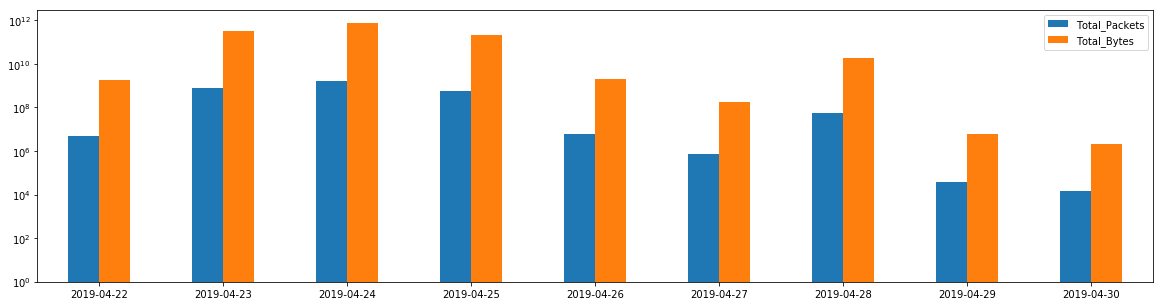

In [164]:
data_df = date_filter(flowlogs_df, 2019, 4, 1, 2019, 5, 1)
tot_df = data_df.set_index('Start')[['Total_Packets', 'Total_Bytes']].resample('1D').sum().fillna(0)
tot_df.index = tot_df.index.date
tot_df.plot.bar(rot=0, log=True, figsize=(20, 5))
plt.show()

# One-Way Flows

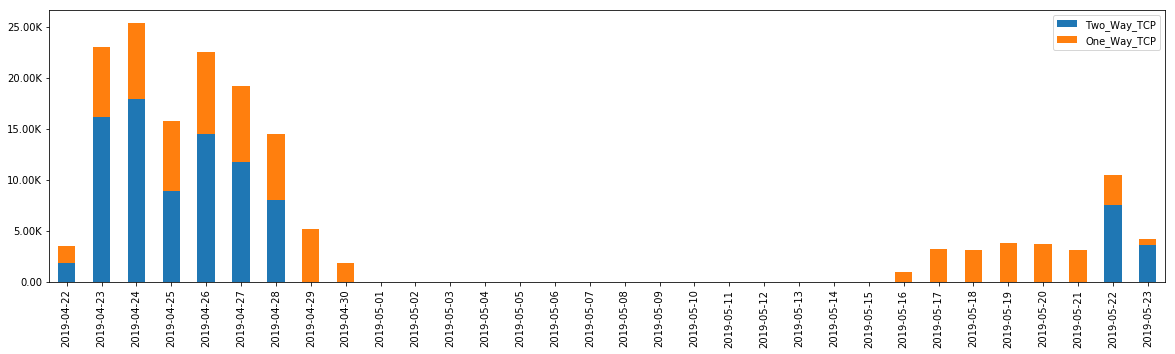

In [170]:
indices = flowlogs_df.set_index('Start').resample('1D').count().index
twowaytcp = flowlogs_df[(flowlogs_df['ABPackets'] != 0) & (flowlogs_df['BAPackets'] != 0) & (flowlogs_df['Protocol'] == "TCP")].set_index('Start').iloc[:, 0].resample('1D').count().fillna(0).values
onewaytcp = flowlogs_df[((flowlogs_df['ABPackets'] == 0) | (flowlogs_df['BAPackets'] == 0)) & (flowlogs_df['Protocol'] == "TCP")].set_index('Start').iloc[:, 0].resample('1D').count().fillna(0).values
tcp_df = pd.DataFrame(index=indices, columns=["Two_Way_TCP", "One_Way_TCP"])
tcp_df["Two_Way_TCP"] = twowaytcp
tcp_df["One_Way_TCP"] = onewaytcp
tcp_df.index = tcp_df.index.date
ax = tcp_df.plot.bar(stacked=True, figsize=(20, 5))
vals = ax.get_yticks()
ax.set_yticklabels([number_format(x) for x in vals])
plt.show()

# Hotspots

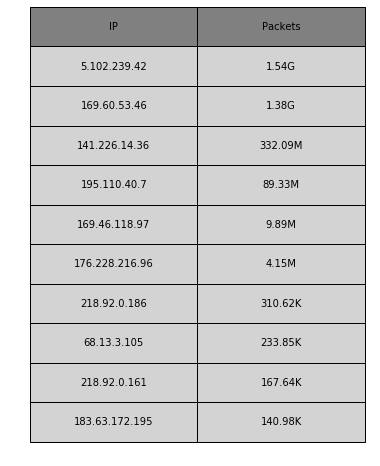

In [41]:
# Select number of hotspots to detect
hotspots_num = 10
src_df = flowlogs_df.groupby(['src_ip']).agg({'ABPackets':'sum'}).rename(columns={"ABPackets": "Packets"})
dst_df = flowlogs_df.groupby(['dst_ip']).agg({'BAPackets':'sum'}).rename(columns={"BAPackets": "Packets"})
tot_df = pd.concat([src_df, dst_df])
tot_df = tot_df.groupby(tot_df.index).agg({'Packets':'sum'}).sort_values(by=['Packets'], ascending=False).head(hotspots_num)
tot_df["Packets"] = tot_df["Packets"].apply(number_format)
tot_df["IP"] = tot_df.index
tot_df = tot_df[["IP", "Packets"]]
plt.table(cellText=tot_df.values, colLabels=tot_df.columns, cellLoc='center', bbox=[0,0,1,0.2*(hotspots_num+1)], cellColours=[['lightgrey']*2]*hotspots_num, colColours=['grey']*2)
plt.axis('off')
plt.show()

# Rejection Percentage by Source

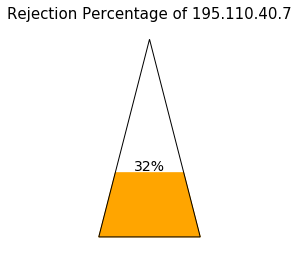

In [67]:
## Insert an IP address 
ip = "195.110.40.7"
src_df = flowlogs_df.loc[flowlogs_df['src_ip'] == ip]
rejection_ratio = 100 * len(src_df.loc[src_df['Action'] == "REJECTED"].index) / len(src_df.index)
rejection_str = str(int(rejection_ratio)) + "%" 

pts1 = [(-1, 0), (1, 0), (0, 100)]
pts2 = [(-1, 0), (-1+rejection_ratio*0.01, rejection_ratio), (1-rejection_ratio*0.01, rejection_ratio), (1, 0)]
plt.figure(figsize=(2,4))
ax = plt.subplot(111)
triangle = plt.Polygon(pts1, fill=False, edgecolor='black')
percentage = plt.Polygon(pts2, fill=True, edgecolor='orange', facecolor='orange')
ax.add_patch(percentage)
ax.add_patch(triangle)

ax.plot()
ax.axis('off')
plt.title("Rejection Percentage of %s" % ip, y=1.02, fontdict={'fontsize': 15})
plt.annotate(rejection_str, xy=(0,rejection_ratio+1), ha="center", size=14)

plt.show()

# Total Traffic - Port Distribution

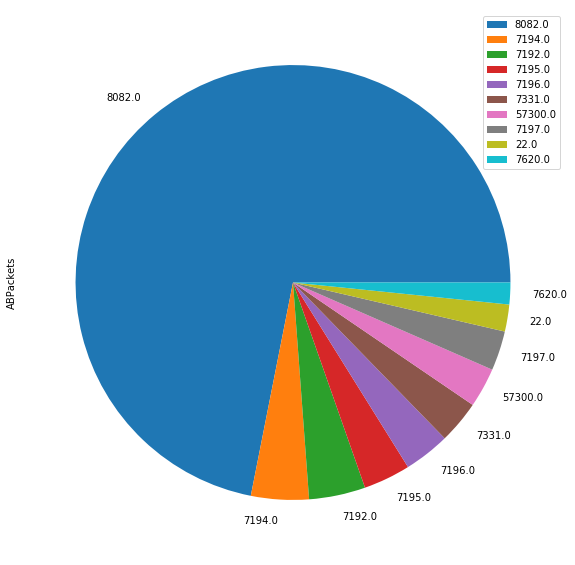

In [69]:
portsAB_df = flowlogs_df.groupby(['dst_port']).agg({'ABPackets':'sum'}).nlargest(10, 'ABPackets')
portsBA_df = flowlogs_df.groupby(['src_port']).agg({'BAPackets':'sum'}).nlargest(10, 'BAPackets').rename(columns={"BAPackets": "ABPackets"})
ports_df = portsAB_df.append(portsBA_df)
res_df = ports_df.groupby(ports_df.index).agg({'ABPackets':'sum'}).nlargest(10, 'ABPackets')
res_df.plot(kind='pie', figsize=(10,10), subplots='True')
plt.show()

# Top Source-Destination Locations of Traffic, by Flows

In [66]:
print("This might take a while, please wait...")
geo = geolite2.reader()
flowlogs_df['src_country'] = flowlogs_df['src_ip'].apply(get_country)
flowlogs_df['dst_country'] = flowlogs_df['dst_ip'].apply(get_country)
geolite2.close()

This might take a while, please wait...


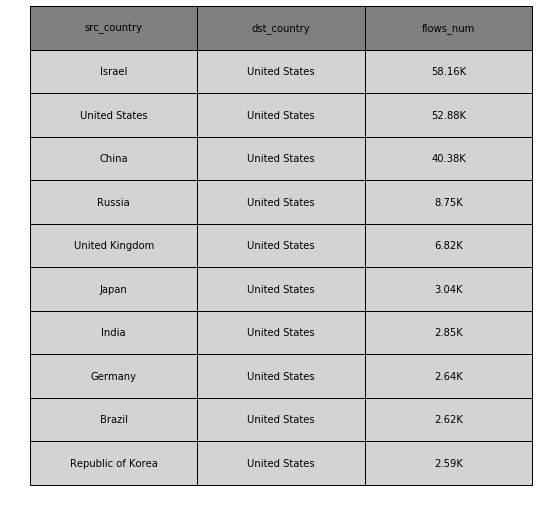

In [67]:
pairs_num = 10
res_df = flowlogs_df.groupby(['src_country', 'dst_country']).size().to_frame('flows_num').nlargest(pairs_num, 'flows_num').reset_index()
res_df["flows_num"] = res_df["flows_num"].apply(number_format)
plt.table(cellText=res_df.values, colLabels=res_df.columns, cellLoc='center', bbox=[0,0,1.5,0.2*(pairs_num+1)], cellColours=[['lightgrey']*3]*pairs_num, colColours=['grey']*3)
plt.axis('off')
plt.show()

# Inbound/Outbound Packets by Source

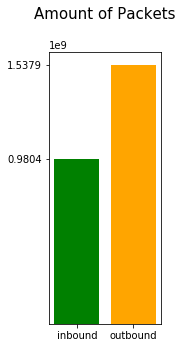

In [71]:
## Insert an IP address 
ip = "5.102.239.42"
src_df = flowlogs_df.loc[flowlogs_df['src_ip'] == ip]
dst_df = flowlogs_df.loc[flowlogs_df['dst_ip'] == ip]

inbound = np.nan_to_num(src_df["BAPackets"].sum()) + np.nan_to_num(dst_df["ABPackets"].sum())
outbound = np.nan_to_num(src_df["ABPackets"].sum()) + np.nan_to_num(dst_df["BAPackets"].sum())

plt.figure(figsize=(2,5))
plt.xticks([1, 2], ["inbound", "outbound"]), plt.yticks([inbound, outbound])
plt.bar([1], [inbound], color='green'), plt.bar([2], [outbound], color='orange')
plt.title("Amount of Packets", y=1.1, fontdict={'fontsize': 15})
plt.show()

# Average Packet Size

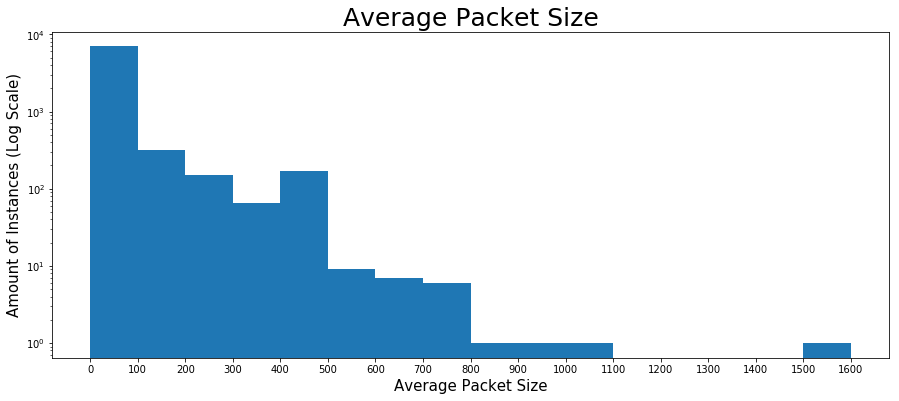

In [23]:
inverted_df = flowlogs_df.rename(columns={"BAPackets":"ABPackets", "ABPackets":"BAPackets", "BABytes":"ABBytes", "ABBytes":"BABytes"}).append(flowlogs_df, sort=True).groupby(['src_ip']).agg({'ABPackets':'sum', 'ABBytes':'sum'})
inverted_df["avg_size"] = inverted_df["ABBytes"] / inverted_df["ABPackets"]
plt.figure(figsize=(15,6))
bins = [100 * i for i in range(int(2 + 0.01*np.max(inverted_df["avg_size"].values)))]
plt.hist(inverted_df["avg_size"], log=True, bins=bins)
plt.xticks(bins)
plt.title("Average Packet Size", size=25)
plt.xlabel('Average Packet Size', size=15), plt.ylabel('Amount of Instances (Log Scale)', size=15)
plt.show()

# Top-N Talking Pairs, by Chosen Metric

The top talking pair is (5.102.239.42, 169.60.53.46),
While 61.07% of the traffic goes from 5.102.239.42 to 169.60.53.46





/opt/conda/envs/Python36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


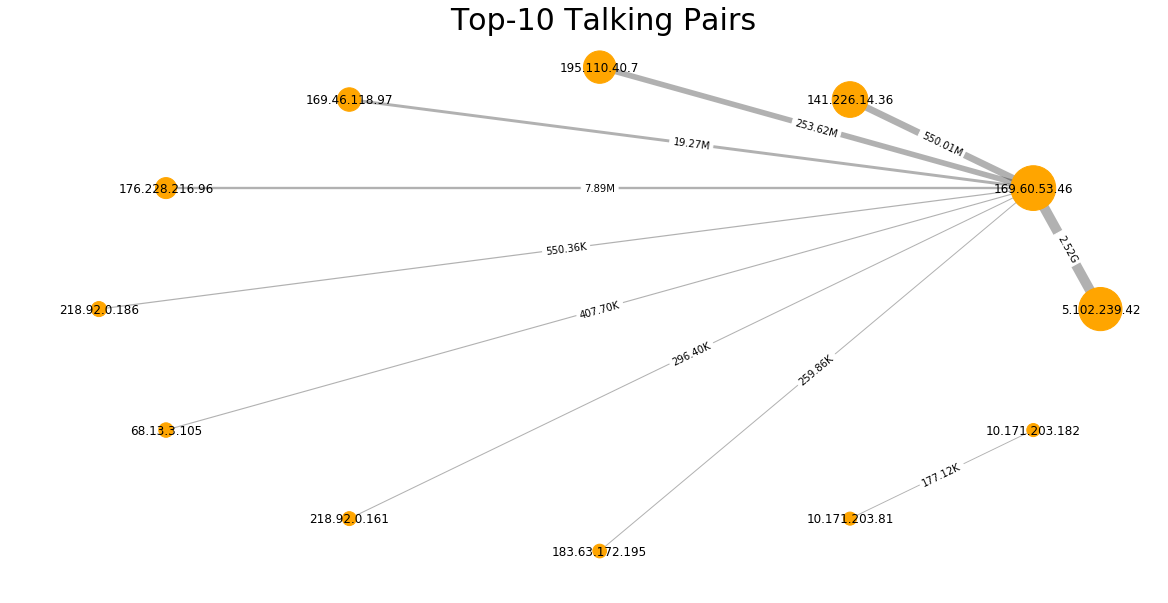

In [73]:
# Insert amout of pairs
N = 10
AB_df = flowlogs_df.loc[flowlogs_df["src_ip"] > flowlogs_df["dst_ip"]]
BA_df = flowlogs_df.loc[flowlogs_df["dst_ip"] > flowlogs_df["src_ip"]].rename(columns={"src_ip":"dst_ip", "dst_ip":"src_ip", "ABPackets":"BAPackets", "BAPackets":"ABPackets"})
ordered_df = AB_df.append(BA_df)
    
res_df = ordered_df.groupby(['src_ip', 'dst_ip']).agg({"Total_Packets":'sum', "ABPackets":'sum', "BAPackets":'sum'}).nlargest(N, 'Total_Packets').sort_values(by=["Total_Packets"], ascending=False).reset_index()

ip1, ip2, stream1, stream2 = res_df.iloc[0][["src_ip", "dst_ip", "ABPackets", "BAPackets"]]
A, B, AB, BA = (ip1, ip2, stream1, stream2) if stream1 > stream2 else (ip2, ip1, stream2, stream1)

print("The top talking pair is (%s, %s)," % (A,  B))
print("While %.2f%% of the traffic goes from %s to %s\n\n\n" % (100*AB/(AB + BA), A,  B))

# Plot Graph

plt.figure(figsize=(20,10))

edges = [(res_df['src_ip'].iloc[i], res_df['dst_ip'].iloc[i], {'weight': res_df['Total_Packets'].iloc[i]}) for i in range(len(res_df.index))]

G = nx.OrderedGraph()
G.add_edges_from(edges)

# positions for all nodes
pos = nx.circular_layout(G) 

# labels
nx.draw_networkx_labels(G, pos)

# edge widths
widths = scale(res_df['Total_Packets'].values, 10)

# edges
nx.draw_networkx_edges(G, pos, width=widths, alpha=0.3)

# node sizes
sizes = scale([elem[1] for elem in G.degree(weight='weight')], 2000)

nx.draw_networkx_nodes(G, pos, node_color = 'orange', node_size = sizes)

# weights
labels = nx.get_edge_attributes(G, 'weight')
for key, value in labels.items():
    labels[key] = number_format(value)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.axis('off')
plt.title('Top-%s Talking Pairs' % N, fontsize=30)
plt.show()

# Alerts

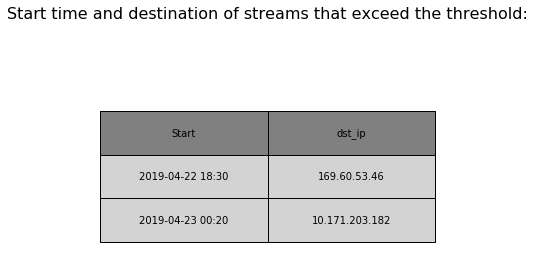

In [63]:
# Select threshold of flows and duration (by hours)
threshold = 500
duration = 1
sorted_df = flowlogs_df.sort_values(by=['dst_ip', 'Start'])
shifted_df = sorted_df.shift(-threshold)
sorted_df['Diff'] = (shifted_df['Start'] - sorted_df['Start']).astype('timedelta64[h]')
alerts_df = sorted_df.loc[(sorted_df['Diff'] < duration) & (shifted_df['dst_ip'] == sorted_df["dst_ip"])]
alerts_df = alerts_df.loc[alerts_df["dst_ip"] != alerts_df.shift()["dst_ip"]]
alerts_df = alerts_df[["Start", "dst_ip"]].sort_values(by=['Start'])
alerts_df["Start"] = alerts_df["Start"].apply(lambda t: t.strftime('%Y-%m-%d %H:%M'))

plt.table(cellText=alerts_df.values, colLabels=alerts_df.columns, cellLoc='center', bbox=[0,0,1,0.2*(len(alerts_df.index)+1)], cellColours=[['lightgrey']*2]*len(alerts_df.index), colColours=['grey']*2)
plt.title("Start time and destination of streams that exceed the threshold:", fontsize=16)
plt.axis('off')
plt.show()

# Anomaly Detection

## Preapare Time-Series Data

In [68]:
# "data_name" is the name of the chosen dataset
data_name = "Art_data"
# "data_df" consists of one column, which is the original signal we try to predict
data_df = get_data(data_name).iloc[0:2000]

split_index = int(0.8*len(data_df.index))
train_df, test_df = standardize(data_df[:split_index]), standardize(data_df[split_index:])
train_set, train_labels = shingle(train_df, window=64)
test_set, test_labels = shingle(test_df, window=64)

train_size, test_size = len(train_set.index), len(test_set.index)
sample_len, label_len = len(train_set.columns), len(train_labels.columns)

In [86]:
training_phase = FC_autoencoder(train_set, test_set, max_epochs=100, batch_size=64, is_initial=False, tolerance=30)

Model restored.
Start training...
epoch: 0, train loss: 0.756837
epoch: 10, train loss: 0.753256
epoch: 20, train loss: 0.75021
epoch: 30, train loss: 0.747589
epoch: 40, train loss: 0.745314
epoch: 50, train loss: 0.743323
epoch: 60, train loss: 0.741572
epoch: 70, train loss: 0.740027
epoch: 80, train loss: 0.738663
epoch: 90, train loss: 0.737455
Training finished and saved. Calculating results...
Done. Averaged test loss: 0.280119


In [26]:
train_set = FC_autoencoder(train_set, train_set, max_epochs=0, batch_size=64, initial=False, tolerance=5)
test_set = FC_autoencoder(test_set, test_set, max_epochs=0, batch_size=64, initial=False, tolerance=5)

Model restored.
Start training...
Training finished and saved. Calculating results...
Done. Averaged test loss: 0.728791
Model restored.
Start training...
Training finished and saved. Calculating results...
Done. Averaged test loss: 0.267797


## 1D Time-Series Anomaly Visualization

In [88]:
sample_len = len(train_set.columns)
pred = cnn_regression(train_set, test_set, train_labels, test_labels, max_epochs=200, batch_size=64, is_initial=True, tolerance=30)

Model initialized.
Start training...
epoch: 0, train loss: 1.82573
epoch: 10, train loss: 1.0085
epoch: 20, train loss: 0.933844
epoch: 30, train loss: 0.896116
epoch: 40, train loss: 0.874081
epoch: 50, train loss: 0.85975
epoch: 60, train loss: 0.849584
Overfitting, early stopping...
Training finished and saved. Calculating results...
Done. Averaged test loss: 0.485706


/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


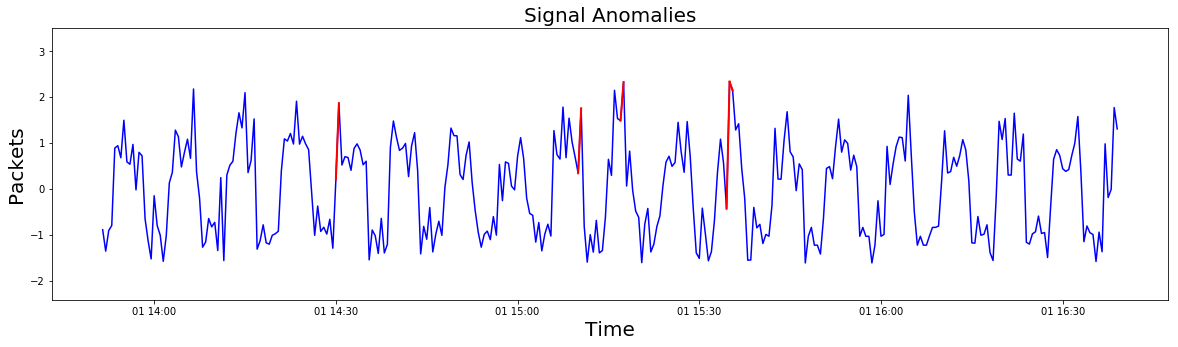

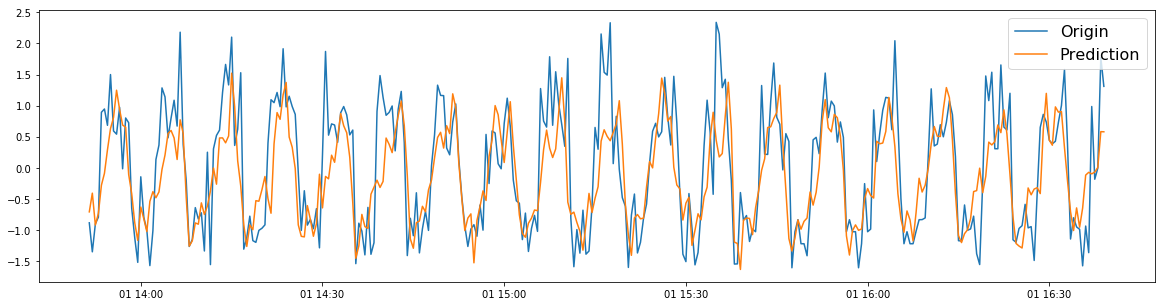

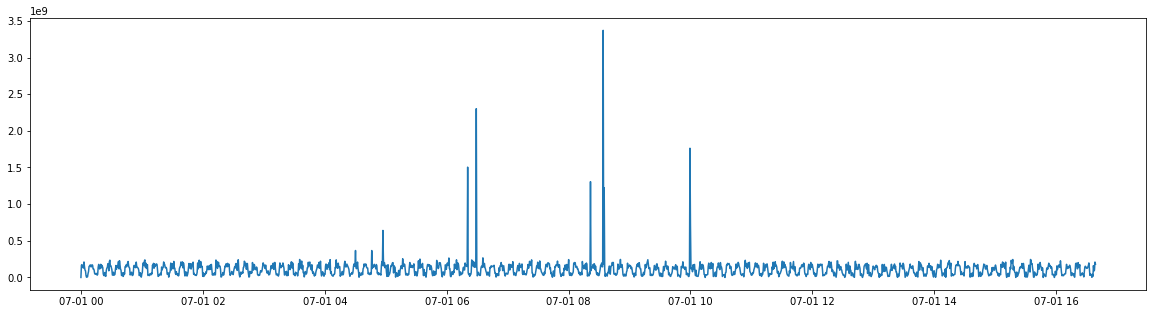

In [89]:
actual = np.reshape(test_labels.values, len(test_labels.index))
scores = np.abs(actual - pred)
anomalies = find_anomalies_static(scores, thresh=3)

xaxis = test_set.index.to_pydatetime() if data_name not in ["Ext_data", "Art_data"] else test_set.index.values
yaxis = [test_df.loc[x] for x in xaxis]


anomaly_visualization(xaxis, yaxis, anomalies, draw_trends=False)

plt.figure(figsize=(20, 5))
plt.plot(xaxis, yaxis, xaxis, pred)
plt.legend(["Origin", "Prediction"], prop={'size': 16})

plt.figure(figsize=(20, 5))
plt.plot(data_df)

plt.show()

## Confusion Matrix

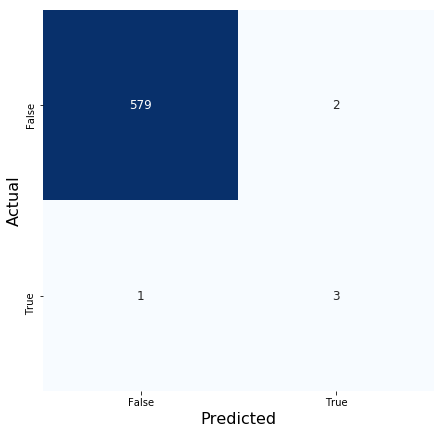

In [437]:
my, their = [0] * test_size, [0] * test_size

anomalies_x = [xaxis[i] for i in anomalies]
for i in anomalies_x:
    my[i-xaxis[0]] = 1
    
anom_df = ext_data.iloc[test_set.index.values]
anom_df = anom_df[anom_df["is_anom"] == True]
for i in anom_df.index.values:
    their[i-xaxis[0]] = 1

plot_confusion_matrix(their, my)